# Autotalker Batch Integration

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 20.01.2023
- **Date of Last Modification:** 26.01.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../autotalker")

In [3]:
import argparse
import os
import pickle
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scib
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context
from sklearn.decomposition import KernelPCA

from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=51, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 52182), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=51, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 52192), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=51, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 52196), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbir

### 1.2 Define Parameters

In [4]:
## Dataset
dataset = "seqfish_mouse_organogenesis"
batch1 = "embryo1_z2"
batch2 = "embryo1_z5"
batch3 = "embryo2_z2"
batch4 = "embryo2_z5"
batch5 = "embryo3_z2"
batch6 = "embryo3_z5"
n_neighbors = 4 # 12

## Model
# AnnData Keys
counts_key = "counts"
cell_type_key = "celltype_mapped_refined"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
latent_key = "autotalker_latent"
condition_key = "batch"

# Architecture
active_gp_thresh_ratio = 0.03
gene_expr_recon_dist = "nb"
n_cond_embed = 3

# Trainer
n_epochs = 40
n_epochs_all_gps = 20
lr = 0.001
lambda_edge_recon = 0.005 # 0.001 for 12 neighbors
lambda_gene_expr_recon = 0.00165 # 0.00033 for 12 neighbors

## Others
random_seed = 42
load_timestamp = None

### 1.3 Run Notebook Setup

In [5]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [6]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [7]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Create Directories

In [8]:
# Define paths
figure_folder_path = f"../figures/{dataset}/batch_integration/{current_timestamp}"
model_artifacts_folder_path = f"../artifacts/{dataset}/batch_integration/{current_timestamp}"
gp_data_folder_path = "../datasets/gp_data" # gene program data
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(model_artifacts_folder_path, exist_ok=True)

## 2. Data

### 2.1 Load Data & Compute Spatial Neighbor Graph

In [9]:
adata_batch1 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch1}.h5ad")
adata_batch2 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch2}.h5ad")
adata_batch3 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch3}.h5ad")
adata_batch4 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch4}.h5ad")
adata_batch5 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch5}.h5ad")
adata_batch6 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch6}.h5ad")

adata_batch_list = [adata_batch1,
                    adata_batch2,
                    adata_batch3,
                    adata_batch4,
                    adata_batch5,
                    adata_batch6]

In [10]:
for adata_batch in adata_batch_list:
    # Compute (separate) spatial neighborhood
    sq.gr.spatial_neighbors(adata_batch,
                            coord_type="generic",
                            spatial_key=spatial_key,
                            n_neighs=n_neighbors)
    # Make adjacency matrix symmetric
    adata_batch.obsp["spatial_connectivities"] = adata_batch.obsp["spatial_connectivities"].maximum(
        adata_batch.obsp["spatial_connectivities"].T)

### 2.2 Combine Data for One-Shot Batch Integration

In [11]:
adata_one_shot = ad.concat(adata_batch_list, join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch1 = sp.csr_matrix((adata_batch1.shape[0],
                                                 (adata_batch2.shape[0] +
                                                  adata_batch3.shape[0] +
                                                  adata_batch4.shape[0] +
                                                  adata_batch5.shape[0] +
                                                  adata_batch6.shape[0])))
connectivities_extension_batch2_before = sp.csr_matrix((adata_batch2.shape[0],
                                                        adata_batch1.shape[0]))
connectivities_extension_batch2_after = sp.csr_matrix((adata_batch2.shape[0],
                                                       (adata_batch3.shape[0] +
                                                        adata_batch4.shape[0] +
                                                        adata_batch5.shape[0] +
                                                        adata_batch6.shape[0])))
connectivities_extension_batch3_before = sp.csr_matrix((adata_batch3.shape[0],
                                                        (adata_batch1.shape[0] +
                                                         adata_batch2.shape[0])))
connectivities_extension_batch3_after = sp.csr_matrix((adata_batch3.shape[0],
                                                       (adata_batch4.shape[0] +
                                                        adata_batch5.shape[0] +
                                                        adata_batch6.shape[0])))
connectivities_extension_batch4_before = sp.csr_matrix((adata_batch4.shape[0],
                                                        (adata_batch1.shape[0] +
                                                         adata_batch2.shape[0] +
                                                         adata_batch3.shape[0])))
connectivities_extension_batch4_after = sp.csr_matrix((adata_batch4.shape[0],
                                                       (adata_batch5.shape[0] +
                                                        adata_batch6.shape[0])))
connectivities_extension_batch5_before = sp.csr_matrix((adata_batch5.shape[0],
                                                        (adata_batch1.shape[0] +
                                                         adata_batch2.shape[0] +
                                                         adata_batch3.shape[0] +
                                                         adata_batch4.shape[0])))
connectivities_extension_batch5_after = sp.csr_matrix((adata_batch5.shape[0],
                                                       adata_batch6.shape[0]))
connectivities_extension_batch6 = sp.csr_matrix((adata_batch6.shape[0],
                                                 (adata_batch1.shape[0] +
                                                  adata_batch2.shape[0] +
                                                  adata_batch3.shape[0] +
                                                  adata_batch4.shape[0] +
                                                  adata_batch5.shape[0])))

connectivities_batch1 = sp.hstack((adata_batch1.obsp["spatial_connectivities"],
                                   connectivities_extension_batch1))
connectivities_batch2 = sp.hstack((connectivities_extension_batch2_before,
                                   adata_batch2.obsp["spatial_connectivities"],
                                   connectivities_extension_batch2_after))
connectivities_batch3 = sp.hstack((connectivities_extension_batch3_before,
                                   adata_batch3.obsp["spatial_connectivities"],
                                   connectivities_extension_batch3_after))
connectivities_batch4 = sp.hstack((connectivities_extension_batch4_before,
                                   adata_batch4.obsp["spatial_connectivities"],
                                   connectivities_extension_batch4_after))
connectivities_batch5 = sp.hstack((connectivities_extension_batch5_before,
                                   adata_batch5.obsp["spatial_connectivities"],
                                   connectivities_extension_batch5_after))
connectivities_batch6 = sp.hstack((connectivities_extension_batch6,
                                   adata_batch6.obsp["spatial_connectivities"]))

connectivities = sp.vstack((connectivities_batch1,
                            connectivities_batch2,
                            connectivities_batch3,
                            connectivities_batch4,
                            connectivities_batch5,
                            connectivities_batch6))

adata_one_shot.obsp["spatial_connectivities"] = connectivities

### 2.3 Combine Data for Query-to-Reference Mapping

In [12]:
adata_reference = ad.concat(adata_batch_list[:-1], join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch1 = sp.csr_matrix((adata_batch1.shape[0],
                                                 (adata_batch2.shape[0] +
                                                  adata_batch3.shape[0] +
                                                  adata_batch4.shape[0] +
                                                  adata_batch5.shape[0])))
connectivities_extension_batch2_before = sp.csr_matrix((adata_batch2.shape[0],
                                                        adata_batch1.shape[0]))
connectivities_extension_batch2_after = sp.csr_matrix((adata_batch2.shape[0],
                                                       (adata_batch3.shape[0] +
                                                        adata_batch4.shape[0] +
                                                        adata_batch5.shape[0])))
connectivities_extension_batch3_before = sp.csr_matrix((adata_batch3.shape[0],
                                                        (adata_batch1.shape[0] +
                                                         adata_batch2.shape[0])))
connectivities_extension_batch3_after = sp.csr_matrix((adata_batch3.shape[0],
                                                       (adata_batch4.shape[0] +
                                                        adata_batch5.shape[0])))
connectivities_extension_batch4_before = sp.csr_matrix((adata_batch4.shape[0],
                                                        (adata_batch1.shape[0] +
                                                         adata_batch2.shape[0] +
                                                         adata_batch3.shape[0])))
connectivities_extension_batch4_after = sp.csr_matrix((adata_batch4.shape[0],
                                                        adata_batch5.shape[0]))
connectivities_extension_batch5 = sp.csr_matrix((adata_batch5.shape[0],
                                                 (adata_batch1.shape[0] +
                                                  adata_batch2.shape[0] +
                                                  adata_batch3.shape[0] +
                                                  adata_batch4.shape[0])))

connectivities_batch1 = sp.hstack((adata_batch1.obsp["spatial_connectivities"],
                                   connectivities_extension_batch1))
connectivities_batch2 = sp.hstack((connectivities_extension_batch2_before,
                                   adata_batch2.obsp["spatial_connectivities"],
                                   connectivities_extension_batch2_after))
connectivities_batch3 = sp.hstack((connectivities_extension_batch3_before,
                                   adata_batch3.obsp["spatial_connectivities"],
                                   connectivities_extension_batch3_after))
connectivities_batch4 = sp.hstack((connectivities_extension_batch4_before,
                                   adata_batch4.obsp["spatial_connectivities"],
                                   connectivities_extension_batch4_after))
connectivities_batch5 = sp.hstack((connectivities_extension_batch5,
                                   adata_batch5.obsp["spatial_connectivities"]))

connectivities = sp.vstack((connectivities_batch1,
                            connectivities_batch2,
                            connectivities_batch3,
                            connectivities_batch4,
                            connectivities_batch5))

adata_reference.obsp["spatial_connectivities"] = connectivities

adata_query = adata_batch_list[-1]

In [13]:
adata_reference_query_list = [adata_reference, adata_query]

adata_reference_query = ad.concat(adata_reference_query_list, join="inner")

reference_batches = adata_reference.obs["batch"].unique().tolist()
query_batches = adata_query.obs["batch"].unique().tolist()
adata_reference_query.obs["mapping_entity"] = None
adata_reference_query.obs.loc[adata_reference_query.obs["batch"].isin(reference_batches), "mapping_entity"] = "reference"
adata_reference_query.obs.loc[adata_reference_query.obs["batch"].isin(query_batches), "mapping_entity"] = "query"

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_adata_reference = sp.csr_matrix((adata_reference.shape[0],
                                                          (adata_query.shape[0])))
connectivities_extension_adata_query = sp.csr_matrix((adata_query.shape[0],
                                                      (adata_reference.shape[0])))

connectivities_adata_reference = sp.hstack((adata_reference.obsp["spatial_connectivities"],
                                           connectivities_extension_adata_reference))
connectivities_adata_query = sp.hstack((connectivities_extension_adata_query,
                                       adata_query.obsp["spatial_connectivities"]))

adata_reference_query.obsp["spatial_connectivities"] = sp.vstack((connectivities_adata_reference,
                                                                  connectivities_adata_query))

## 3. Autotalker Model

### 3.1 Prepare Gene Program Mask

In [14]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.01,
    load_from_disk=True,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path)

In [15]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [16]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species="mouse",
    genes_uppercase=True)

In [17]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [18]:
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

Removing GP 'CTF1_ligand_receptor_GP' as it is a subset of GP 'CTF1_ligand_targetgenes_GP'.
Removing GP 'LEP_ligand_receptor_GP' as it is a subset of GP 'LEP_ligand_targetgenes_GP'.
Removing GP 'IL4_ligand_receptor_GP' as it is a subset of GP 'IL4_ligand_targetgenes_GP'.
Removing GP 'IL12A_ligand_receptor_GP' as it is a subset of GP 'IL12A_ligand_targetgenes_GP'.
Removing GP 'IL23A_ligand_receptor_GP' as it is a subset of GP 'IL23A_ligand_targetgenes_GP'.
Removing GP 'CSF2_ligand_receptor_GP' as it is a subset of GP 'CSF2_ligand_targetgenes_GP'.
Removing GP 'IL21_ligand_receptor_GP' as it is a subset of GP 'IL21_ligand_targetgenes_GP'.
Removing GP 'TSLP_ligand_receptor_GP' as it is a subset of GP 'TSLP_ligand_targetgenes_GP'.
Removing GP 'GH2_ligand_receptor_GP' as it is a subset of GP 'GH2_ligand_targetgenes_GP'.
Removing GP 'EGF_ligand_receptor_GP' as it is a subset of GP 'EGF_ligand_targetgenes_GP'.
Removing GP 'IL10_ligand_receptor_GP' as it is a subset of GP 'IL10_ligand_targetgen

In [19]:
for adata in [adata_one_shot, adata_reference, adata_query]:

    # Add the gene program dictionary as binary masks to the adata for model training
    add_gps_from_gp_dict_to_adata(
        gp_dict=combined_new_gp_dict,
        adata=adata,
        genes_uppercase=True,
        gp_targets_mask_key="autotalker_gp_targets",
        gp_sources_mask_key="autotalker_gp_sources",
        gp_names_key="autotalker_gp_names",
        min_genes_per_gp=1,
        min_source_genes_per_gp=0,
        min_target_genes_per_gp=0,
        max_genes_per_gp=None,
        max_source_genes_per_gp=None,
        max_target_genes_per_gp=None,
        filter_genes_not_in_masks=False)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata_one_shot.uns["autotalker_gp_names"])

# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata_one_shot.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(list(adata_one_shot.uns['autotalker_gp_names']), 5)}.")
print(f"Number of gene program target genes: {adata_one_shot.varm['autotalker_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata_one_shot.varm['autotalker_gp_sources'].sum()}.")

Number of gene programs with probed genes: 489.
Example gene programs: ['EDA_ligand_targetgenes_GP', 'RBP3_ligand_receptor_GP', 'WNT11_ligand_receptor_GP', 'JAM2_ligand_targetgenes_GP', 'DLL4_ligand_targetgenes_GP'].
Number of gene program target genes: 7476.
Number of gene program source genes: 127.


### 3.2 One Shot Batch Integration Without Conditional Embedding

#### 3.2.1 Initialize, Train & Save Model

In [20]:
# Initialize model
model = Autotalker(adata_one_shot,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=None,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   n_addon_gps=0,
                   node_label_method="one-hop-attention")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 0, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 0, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 0, n_addon_input: 0, n_output: 702


In [21]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 47311
Number of validation nodes: 5257
Number of training edges: 109836
Number of validation edges: 12204

--- MODEL TRAINING ---
Epoch 1/40 |--------------------| 2.5% val_auroc_score: 0.9268; val_auprc_score: 0.8848; val_best_acc_score: 0.8253; val_best_f1_score: 0.8506; train_kl_reg_loss: 0.0099; train_edge_recon_loss: 0.0289; train_gene_expr_recon_loss: 0.5881; train_group_lasso_reg_loss: 0.0000; train_global_loss: 0.6269; train_optim_loss: 0.6269; val_kl_reg_loss: 0.0095; val_edge_recon_loss: 0.0133; val_gene_expr_recon_loss: 0.5557; val_group_lasso_reg_loss: 0.0000; val_global_loss: 0.5785; val_optim_loss: 0.5785
Epoch 2/40 |█-------------------| 5.0% val_auroc_score: 0.9382; val_auprc_score: 0.9010; val_best_acc_score: 0.8385; val_best_f1_score: 0.8604; train_kl_reg_loss: 0.0123; train_edge_recon_loss: 0.0247; train_gene_expr_recon_loss: 0.5448; train_group_lasso_reg_loss: 0.0000; train_global_loss: 0.5818; train_optim_loss:

In [22]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/one_shot_no_cond_embed",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

#### 3.2.2 Load Model

In [23]:
# Load trained model
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path
    
model = Autotalker.load(dir_path=model_artifacts_load_folder_path + "/one_shot_no_cond_embed",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 0, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 0, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 0, n_addon_input: 0, n_output: 702


#### 3.2.3 Analyze Latent Space

In [24]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


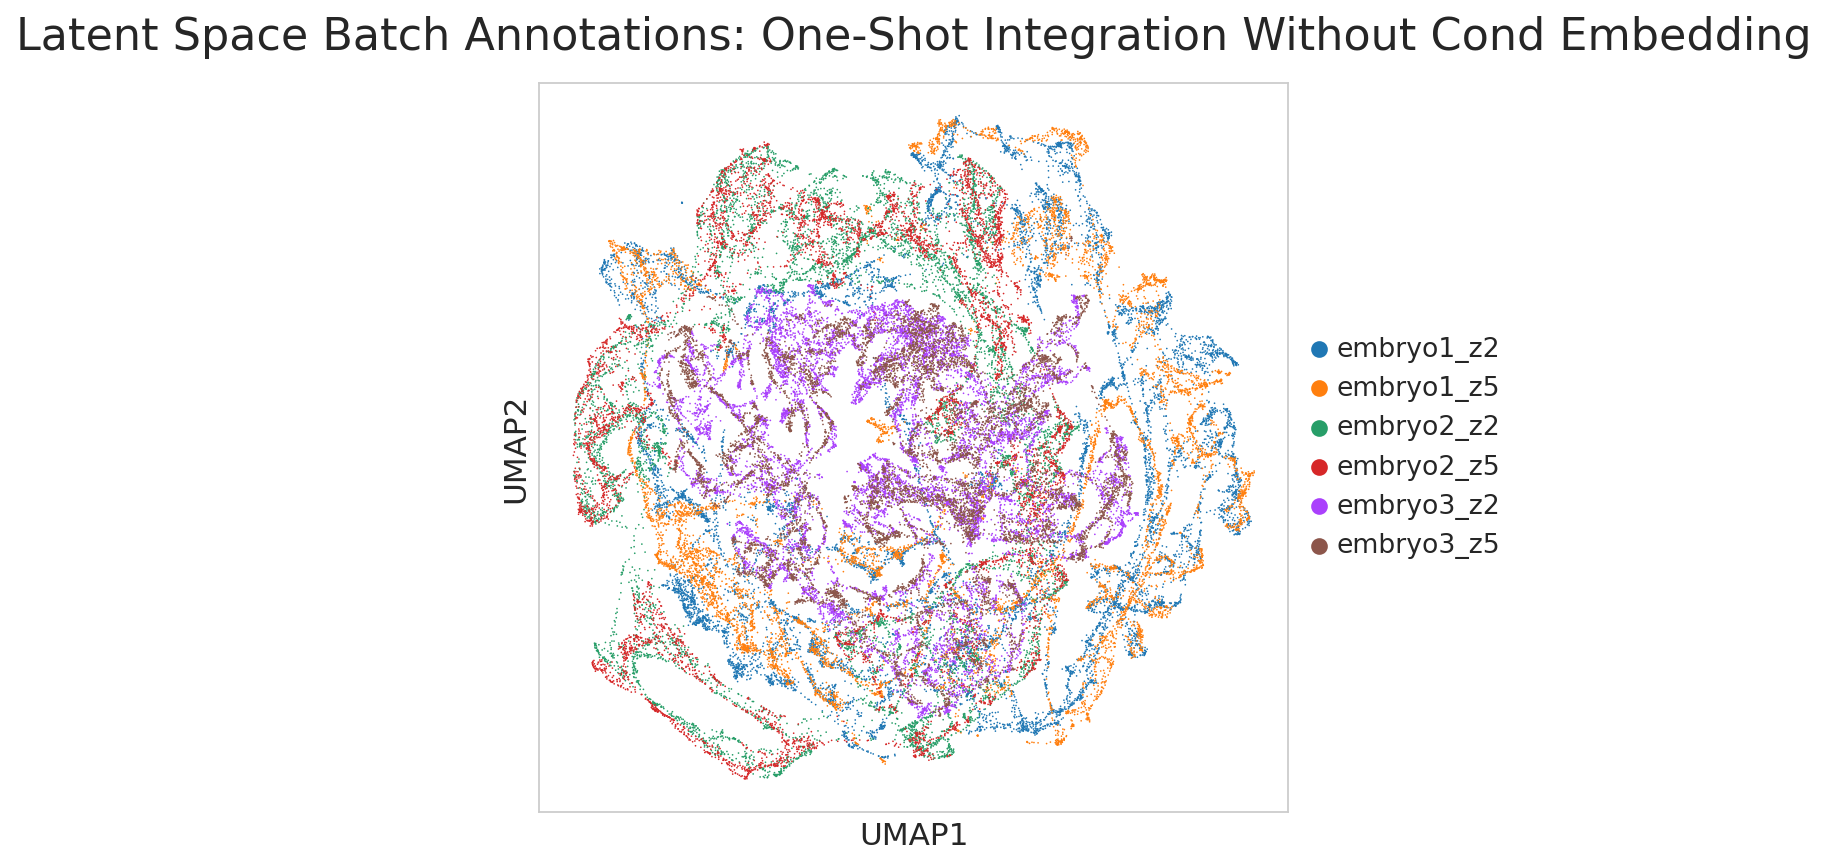

In [25]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Latent Space Batch Annotations: One-Shot Integration Without Cond Embedding", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_one_shot_no_cond_embed.png",
            bbox_inches="tight")

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


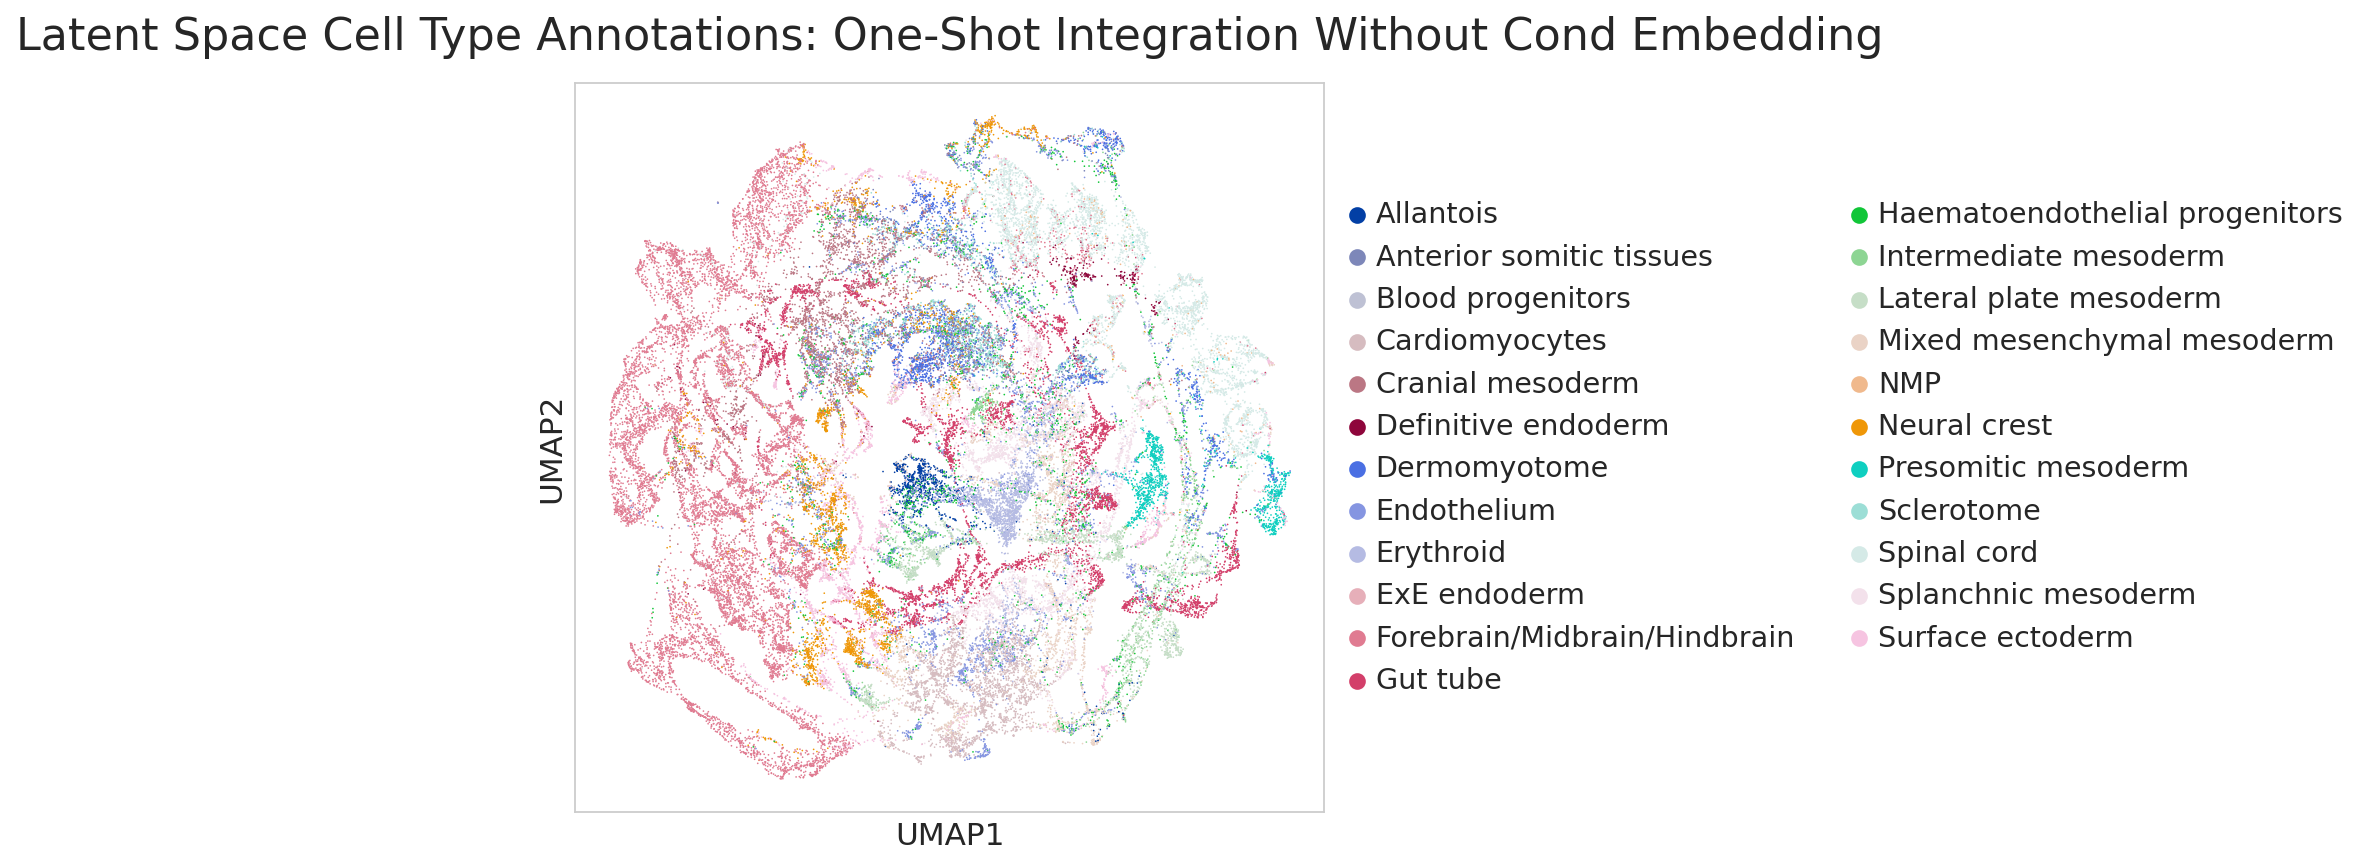

In [26]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("Latent Space Cell Type Annotations: One-Shot Integration Without Cond Embedding", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_one_shot_no_cond_embed.png",
            bbox_inches="tight")

#### 3.2.4 Analyze Batch Correction Metrics

In [27]:
batch_correction_metrics_one_shot_no_cond_embed = {}

batch_correction_metrics_one_shot_no_cond_embed["silhouette_batch"] = scib.me.silhouette_batch(
    model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(batch_correction_metrics_one_shot_no_cond_embed)

# Store to disk
with open(f"{model_artifacts_folder_path}"
          "/batch_correction_metrics_one_shot_no_cond_embed.pickle", "wb") as f:
    pickle.dump(batch_correction_metrics_one_shot_no_cond_embed, f)

mean silhouette per group:                                 silhouette_score
group                                           
Allantois                               0.938504
Anterior somitic tissues                0.957903
Blood progenitors                       0.919005
Cardiomyocytes                          0.966810
Cranial mesoderm                        0.955456
Definitive endoderm                     0.923496
Dermomyotome                            0.948812
Endothelium                             0.969284
Erythroid                               0.968126
ExE endoderm                            0.904691
Forebrain/Midbrain/Hindbrain            0.982841
Gut tube                                0.967085
Haematoendothelial progenitors          0.973130
Intermediate mesoderm                   0.952973
Lateral plate mesoderm                  0.954867
Mixed mesenchymal mesoderm              0.961324
NMP                                     0.938765
Neural crest                            0.

### 3.3 One-Shot Batch Integration With Conditional Embedding

#### 3.3.1 Initialize, Train & Save Model

In [28]:
# Initialize model
model = Autotalker(adata_one_shot,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=["encoder",
                                         "gene_expr_decoder",
                                         "graph_decoder"],
                   n_cond_embed=n_cond_embed,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   n_addon_gps=0,
                   node_label_method="one-hop-attention")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 3, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 3, n_addon_input: 0, n_output: 702


In [29]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 47311
Number of validation nodes: 5257
Number of training edges: 109836
Number of validation edges: 12204

--- MODEL TRAINING ---
Epoch 1/40 |--------------------| 2.5% val_auroc_score: 0.9004; val_auprc_score: 0.8339; val_best_acc_score: 0.7037; val_best_f1_score: 0.7714; train_kl_reg_loss: 0.0170; train_edge_recon_loss: 0.0254; train_gene_expr_recon_loss: 0.5802; train_group_lasso_reg_loss: 0.0000; train_global_loss: 0.6226; train_optim_loss: 0.6226; val_kl_reg_loss: 0.0098; val_edge_recon_loss: 0.0237; val_gene_expr_recon_loss: 0.5342; val_group_lasso_reg_loss: 0.0000; val_global_loss: 0.5677; val_optim_loss: 0.5677
Epoch 2/40 |█-------------------| 5.0% val_auroc_score: 0.9629; val_auprc_score: 0.9325; val_best_acc_score: 0.8362; val_best_f1_score: 0.8592; train_kl_reg_loss: 0.0154; train_edge_recon_loss: 0.0185; train_gene_expr_recon_loss: 0.5208; train_group_lasso_reg_loss: 0.0000; train_global_loss: 0.5546; train_optim_loss:

In [30]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/one_shot_cond_embed",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

#### 3.3.2 Load Model

In [31]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/one_shot_cond_embed",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 3, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 3, n_addon_input: 0, n_output: 702


#### 3.3.3 Analyze Latent Space

In [32]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


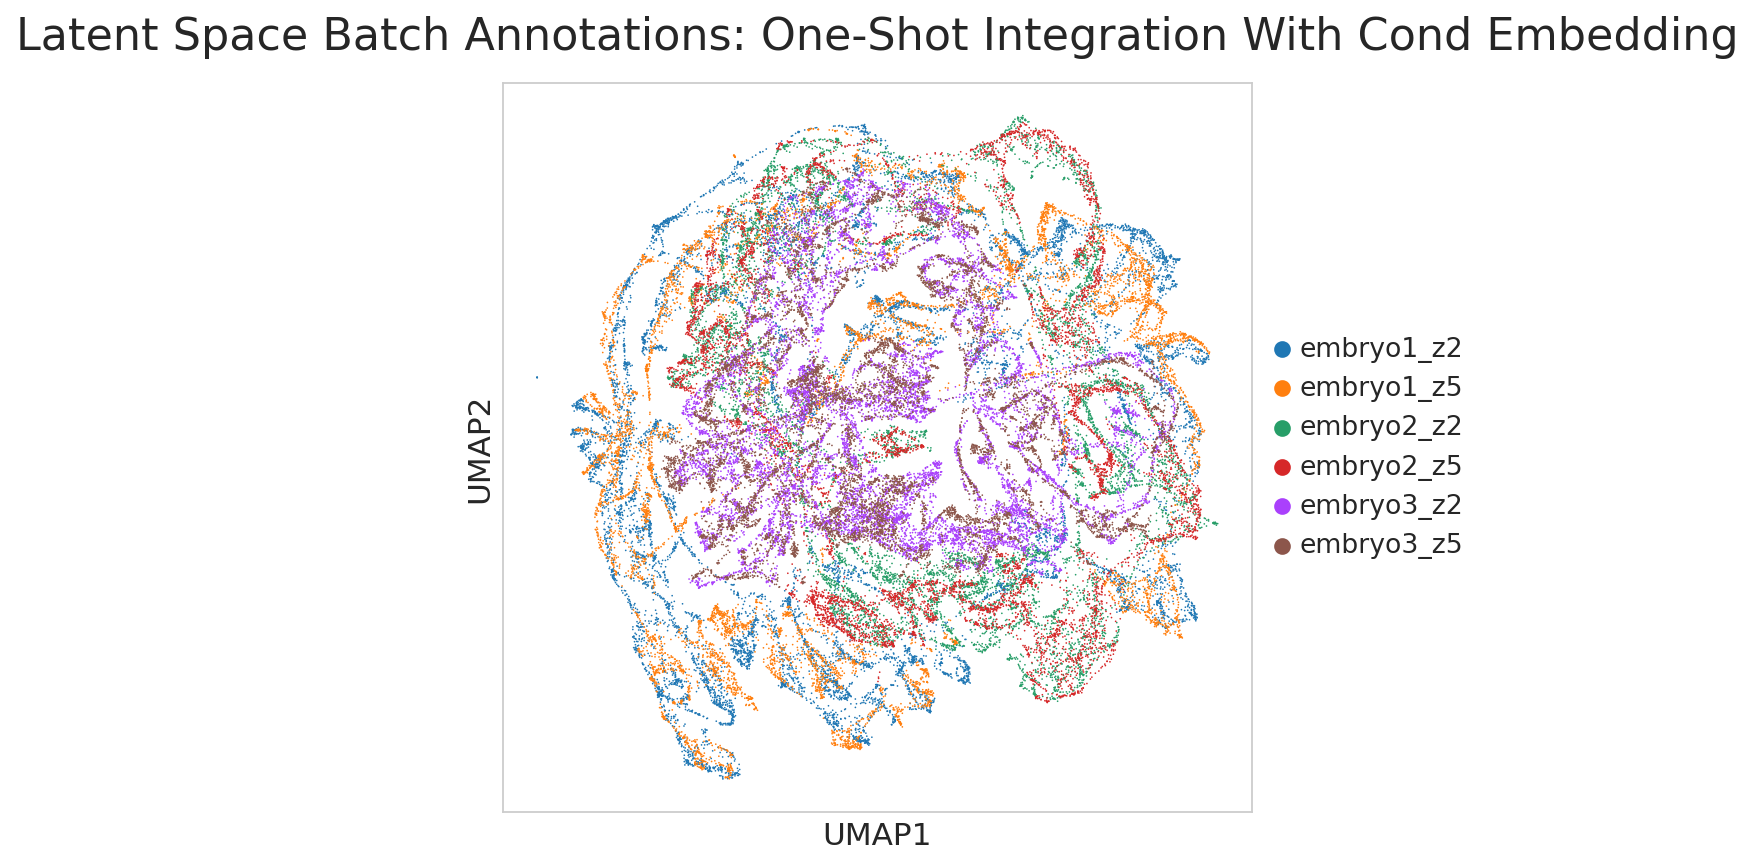

In [33]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Latent Space Batch Annotations: One-Shot Integration With Cond Embedding", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_one_shot_cond_embed.png",
            bbox_inches="tight")

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


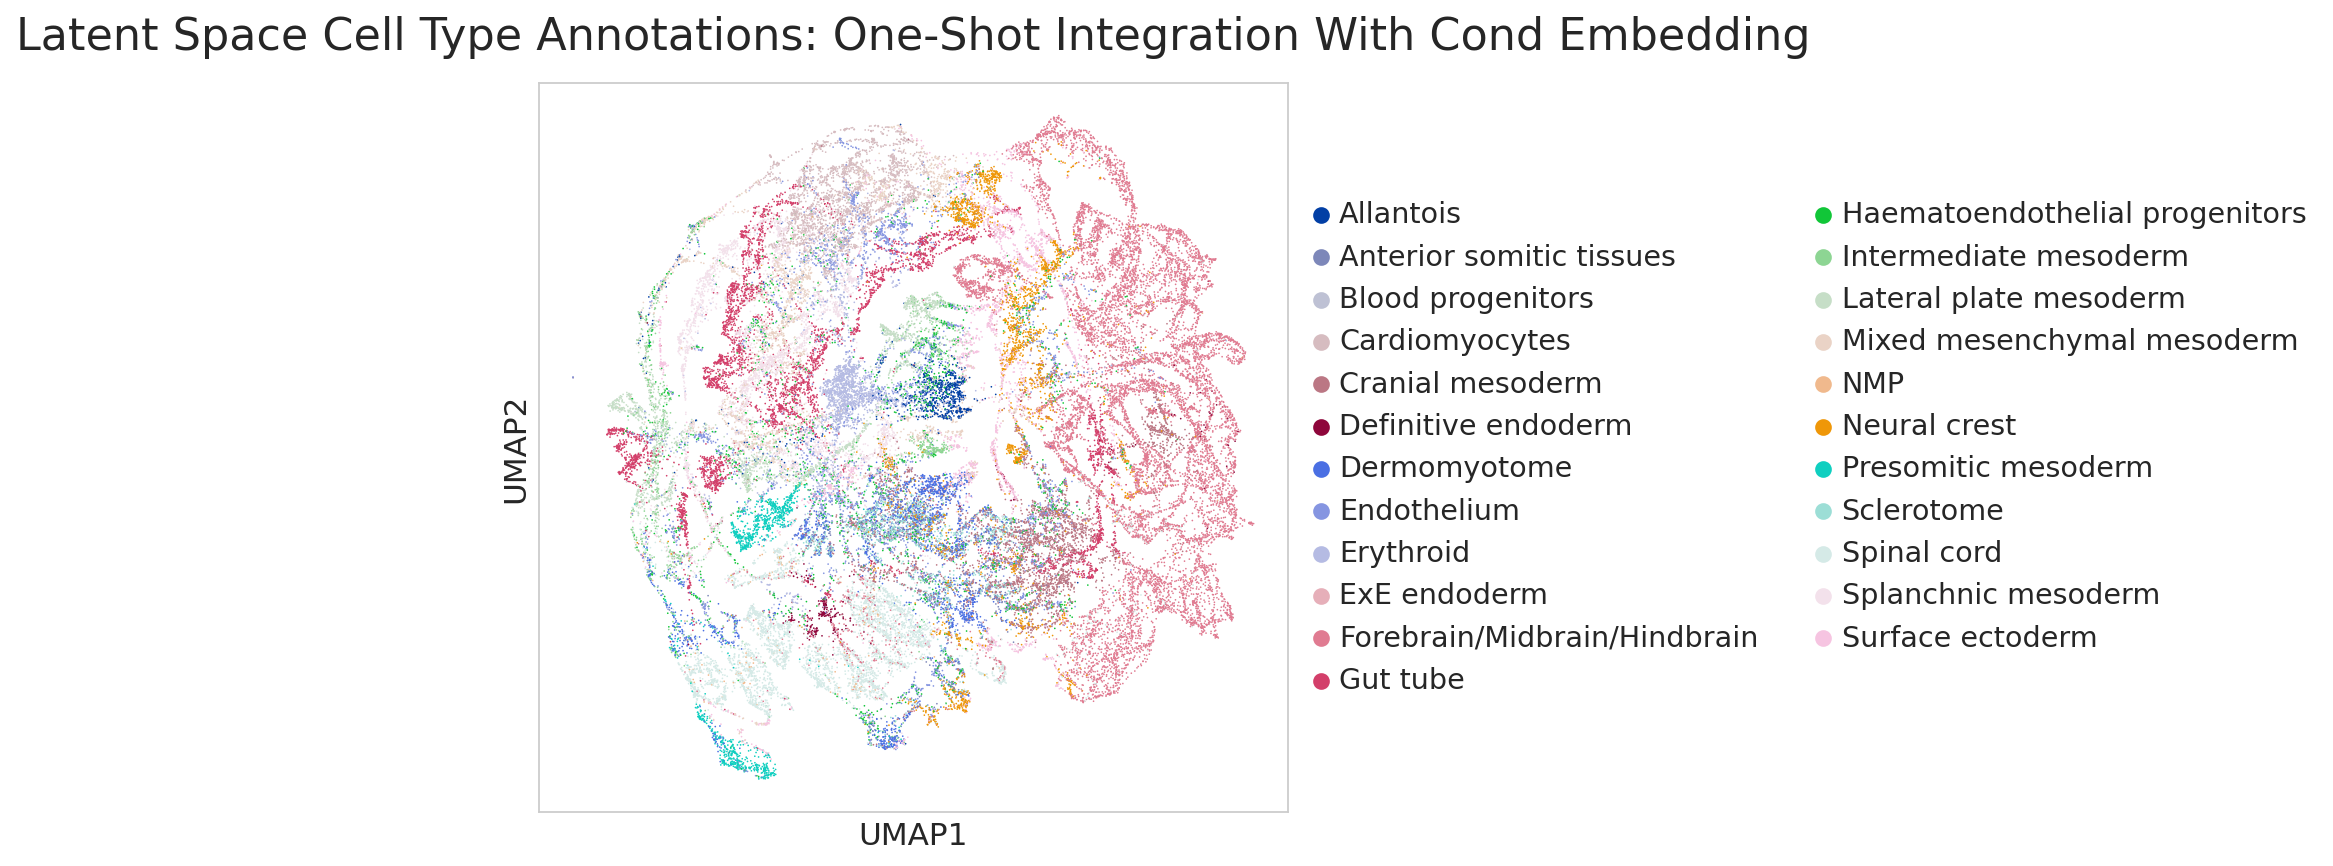

In [34]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("Latent Space Cell Type Annotations: One-Shot Integration With Cond Embedding", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_one_shot_cond_embed.png",
            bbox_inches="tight")

#### 3.3.4 Analyze Batch Correction Metrics

In [35]:
batch_correction_metrics_one_shot_cond_embed = {}

batch_correction_metrics_one_shot_cond_embed["silhouette_batch"] = scib.me.silhouette_batch(
    model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(batch_correction_metrics_one_shot_cond_embed)

# Store to disk
with open(f"{model_artifacts_folder_path}"
          "/batch_correction_metrics_one_shot_cond_embed.pickle", "wb") as f:
    pickle.dump(batch_correction_metrics_one_shot_cond_embed, f)

mean silhouette per group:                                 silhouette_score
group                                           
Allantois                               0.925811
Anterior somitic tissues                0.958551
Blood progenitors                       0.929535
Cardiomyocytes                          0.968413
Cranial mesoderm                        0.957322
Definitive endoderm                     0.922363
Dermomyotome                            0.946961
Endothelium                             0.968739
Erythroid                               0.965453
ExE endoderm                            0.887640
Forebrain/Midbrain/Hindbrain            0.978268
Gut tube                                0.962961
Haematoendothelial progenitors          0.975858
Intermediate mesoderm                   0.951960
Lateral plate mesoderm                  0.949133
Mixed mesenchymal mesoderm              0.961228
NMP                                     0.921701
Neural crest                            0.

#### 3.3.5 Analyze Conditional Embedding

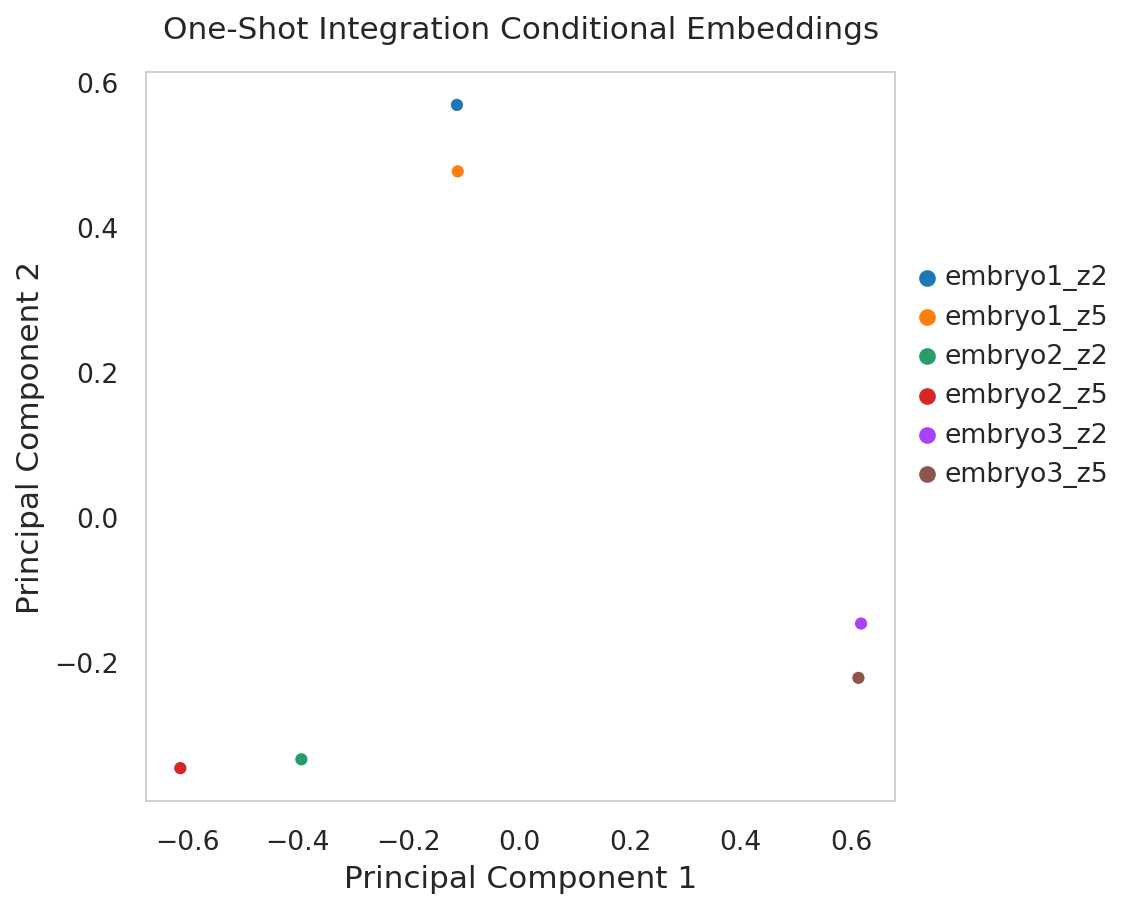

In [36]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
cond = model.adata.obs["batch"].unique()

# Get top 2 principal components and plot them
pca = KernelPCA(n_components=2, kernel="linear")
cond_embed_pca = pca.fit_transform(cond_embed)
sns.scatterplot(x=cond_embed_pca[:, 0], 
                y=cond_embed_pca[:, 1], 
                hue=cond)
plt.title("One-Shot Integration Conditional Embeddings", pad=15)
plt.xlabel("Principal Component 1")
plt.xticks(fontsize=12)
plt.ylabel ("Principal Component 2")
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.75),
           loc=2,
           borderaxespad=0.,
           fontsize=12,
           frameon=False)
plt.savefig(f"{figure_folder_path}/one_shot_cond_embed.png",
            bbox_inches="tight")

### 3.4 Query-to-Reference Mapping

#### 3.4.1 Reference

##### 3.4.1.1 Initialize, Train & Save Model

In [37]:
# Initialize model
model = Autotalker(adata_reference,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=["encoder",
                                         "gene_expr_decoder",
                                         "graph_decoder"],
                   n_cond_embed=n_cond_embed,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   n_addon_gps=0,
                   node_label_method="one-hop-attention")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 3, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 3, n_addon_input: 0, n_output: 702


In [38]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 38844
Number of validation nodes: 4316
Number of training edges: 90041
Number of validation edges: 10004

--- MODEL TRAINING ---
Epoch 1/40 |--------------------| 2.5% val_auroc_score: 0.9604; val_auprc_score: 0.9270; val_best_acc_score: 0.8329; val_best_f1_score: 0.8568; train_kl_reg_loss: 0.0131; train_edge_recon_loss: 0.0255; train_gene_expr_recon_loss: 0.6003; train_group_lasso_reg_loss: 0.0000; train_global_loss: 0.6389; train_optim_loss: 0.6389; val_kl_reg_loss: 0.0111; val_edge_recon_loss: 0.0128; val_gene_expr_recon_loss: 0.5407; val_group_lasso_reg_loss: 0.0000; val_global_loss: 0.5645; val_optim_loss: 0.5645
Epoch 2/40 |█-------------------| 5.0% val_auroc_score: 0.9582; val_auprc_score: 0.9239; val_best_acc_score: 0.8401; val_best_f1_score: 0.8621; train_kl_reg_loss: 0.0148; train_edge_recon_loss: 0.0187; train_gene_expr_recon_loss: 0.5361; train_group_lasso_reg_loss: 0.0000; train_global_loss: 0.5696; train_optim_loss: 

In [39]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/reference",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

##### 3.4.1.2 Load Model

In [40]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 3, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 3, n_addon_input: 0, n_output: 702


##### 3.4.1.3 Analyze Latent Space

In [41]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


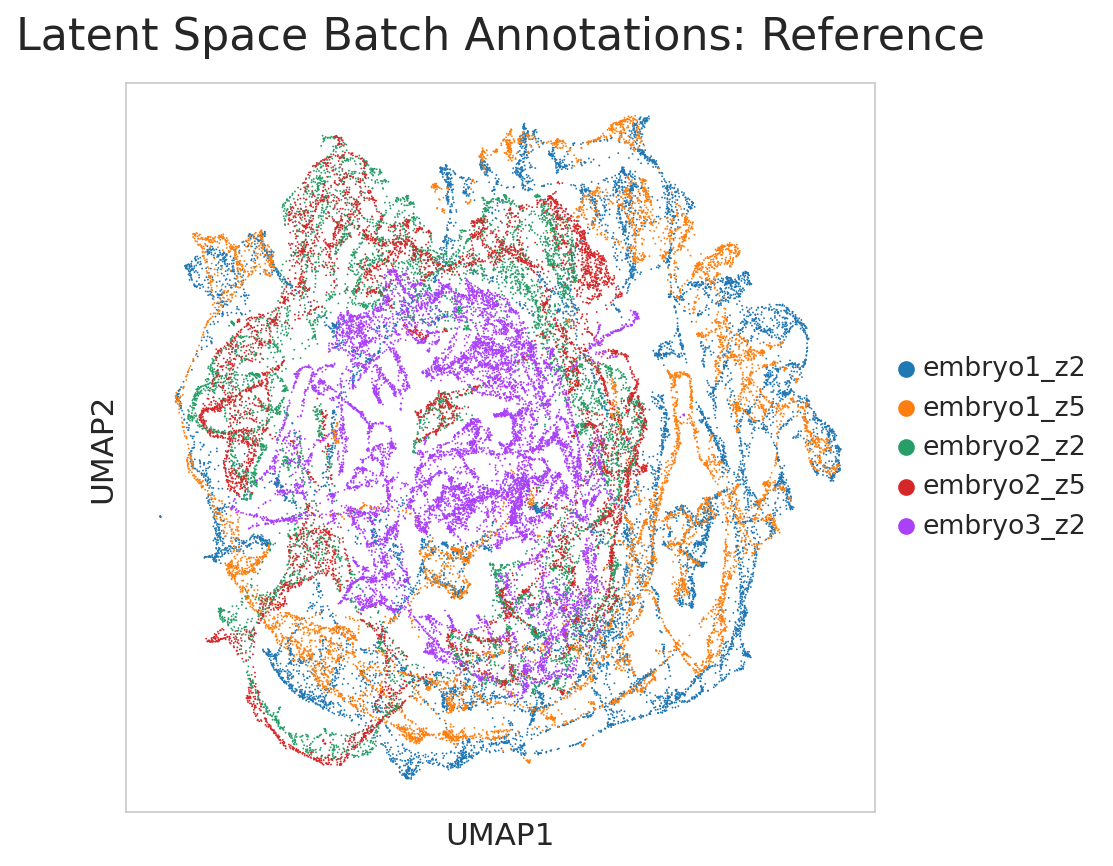

In [42]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Latent Space Batch Annotations: Reference", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_reference.png",
            bbox_inches="tight")

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


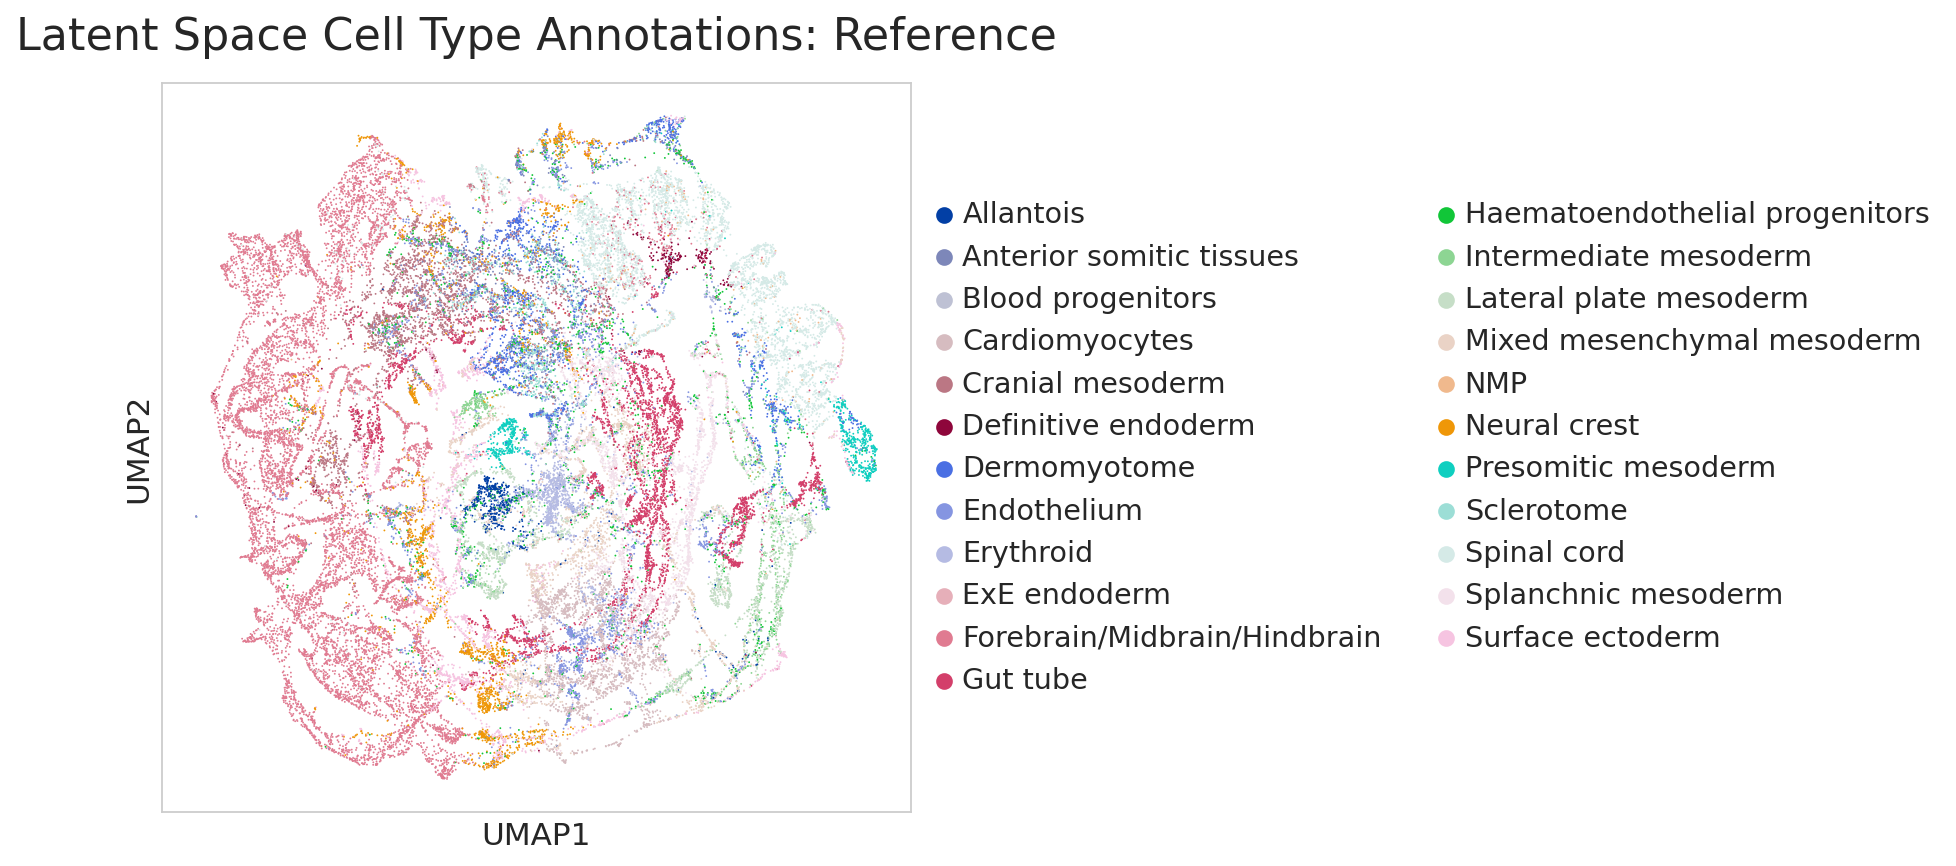

In [43]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("Latent Space Cell Type Annotations: Reference", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_reference.png",
            bbox_inches="tight")

##### 3.4.1.4 Analyze Batch Correction Metrics

In [44]:
batch_correction_metrics_reference = {}

batch_correction_metrics_reference["silhouette_batch"] = scib.me.silhouette_batch(
    model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(batch_correction_metrics_reference)

# Store to disk
with open(f"{model_artifacts_folder_path}"
          "/batch_correction_metrics_reference.pickle", "wb") as f:
    pickle.dump(batch_correction_metrics_reference, f)

mean silhouette per group:                                 silhouette_score
group                                           
Allantois                               0.770359
Anterior somitic tissues                0.950953
Blood progenitors                       0.920034
Cardiomyocytes                          0.961320
Cranial mesoderm                        0.959086
Definitive endoderm                     0.921129
Dermomyotome                            0.931358
Endothelium                             0.970659
Erythroid                               0.885030
ExE endoderm                            0.915086
Forebrain/Midbrain/Hindbrain            0.979118
Gut tube                                0.957596
Haematoendothelial progenitors          0.973134
Intermediate mesoderm                   0.956842
Lateral plate mesoderm                  0.920033
Mixed mesenchymal mesoderm              0.955315
NMP                                     0.933017
Neural crest                            0.

##### 3.4.1.5 Analyze Conditional Embedding

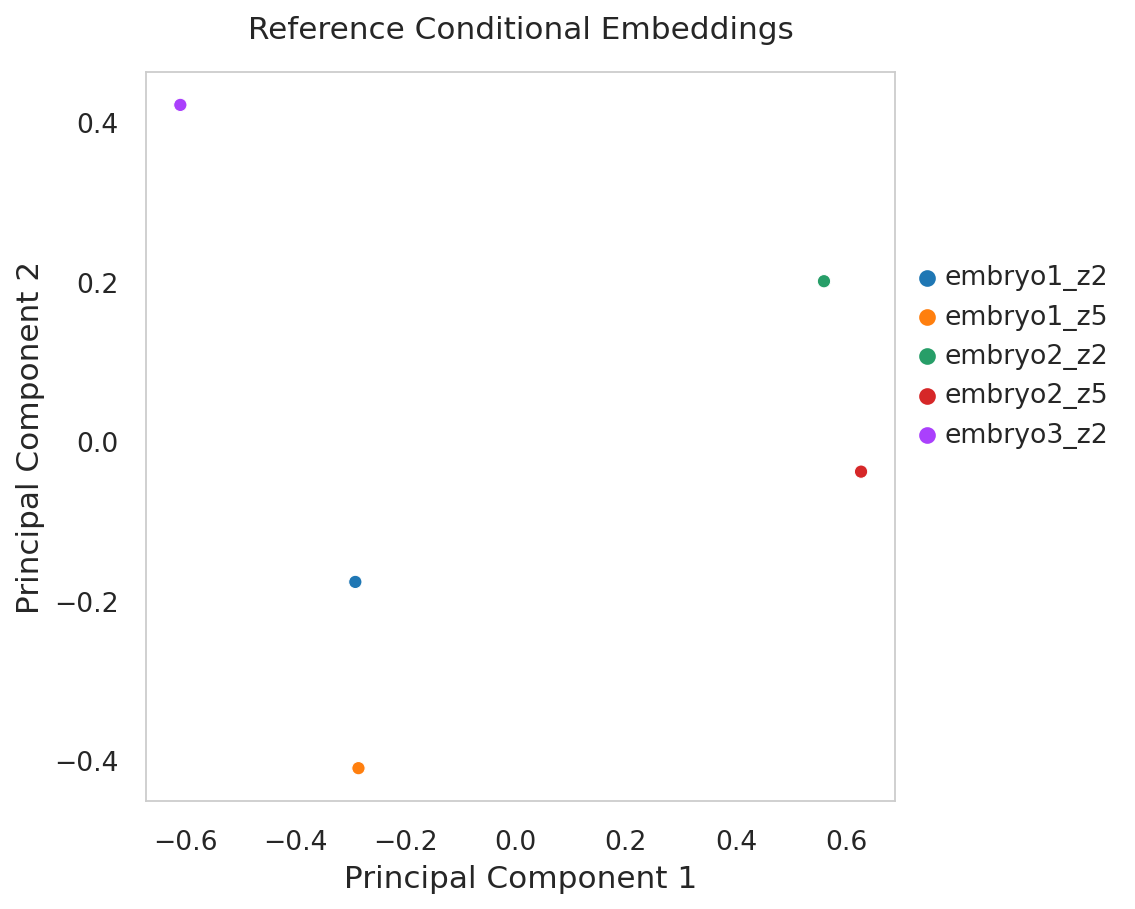

In [45]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
cond = model.adata.obs["batch"].unique()

# Get top 2 principal components and plot them
pca = KernelPCA(n_components=2, kernel="linear")
cond_embed_pca = pca.fit_transform(cond_embed)
sns.scatterplot(x=cond_embed_pca[:, 0], 
                y=cond_embed_pca[:, 1], 
                hue=cond)
plt.title("Reference Conditional Embeddings", pad=15)
plt.xlabel("Principal Component 1")
plt.xticks(fontsize=12)
plt.ylabel ("Principal Component 2")
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.75),
           loc=2,
           borderaxespad=0.,
           fontsize=12,
           frameon=False)
plt.savefig(f"{figure_folder_path}/reference_cond_embed.png",
            bbox_inches="tight")

#### 3.4.2 Query

##### 3.4.2.1 Initialize, Train & Save Model

In [46]:
# Load model trained on reference data for transfer learning with query data
# Freeze all weights except for conditional weights
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference",
                        adata=adata_query,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names",
                        unfreeze_all_weights=False,
                        unfreeze_cond_embed_weights=True)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 3, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 3, n_addon_input: 0, n_output: 702


In [47]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=0.1, # increase learning rate
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 8467
Number of validation nodes: 941
Number of training edges: 19796
Number of validation edges: 2199

--- MODEL TRAINING ---
Epoch 1/40 |--------------------| 2.5% val_auroc_score: 0.5034; val_auprc_score: 0.5017; val_best_acc_score: 0.5000; val_best_f1_score: 0.6667; train_kl_reg_loss: 16.2192; train_edge_recon_loss: 23.0496; train_gene_expr_recon_loss: 0.8605; train_group_lasso_reg_loss: 0.0000; train_global_loss: 40.1293; train_optim_loss: 40.1293; val_kl_reg_loss: 0.0782; val_edge_recon_loss: 0.0790; val_gene_expr_recon_loss: 0.4406; val_group_lasso_reg_loss: 0.0000; val_global_loss: 0.5979; val_optim_loss: 0.5979
Epoch 2/40 |█-------------------| 5.0% val_auroc_score: 0.5023; val_auprc_score: 0.5011; val_best_acc_score: 0.5000; val_best_f1_score: 0.6667; train_kl_reg_loss: 0.0614; train_edge_recon_loss: 0.0747; train_gene_expr_recon_loss: 0.4366; train_group_lasso_reg_loss: 0.0000; train_global_loss: 0.5728; train_optim_loss:

In [48]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/reference_query",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

##### 3.4.2.2 Load Model

In [49]:
# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference_query",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 3, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 3, n_addon_input: 0, n_output: 702


##### 3.4.2.3 Analyze Latent Space

In [50]:
adata_reference_query.uns[gp_names_key] = adata_reference.uns[gp_names_key]

adata_reference_query.obsm[latent_key] = model.get_latent_representation(
    adata=adata_reference_query,
    condition_key="batch")

In [51]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(adata_reference_query, use_rep=latent_key)
sc.tl.umap(adata_reference_query)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


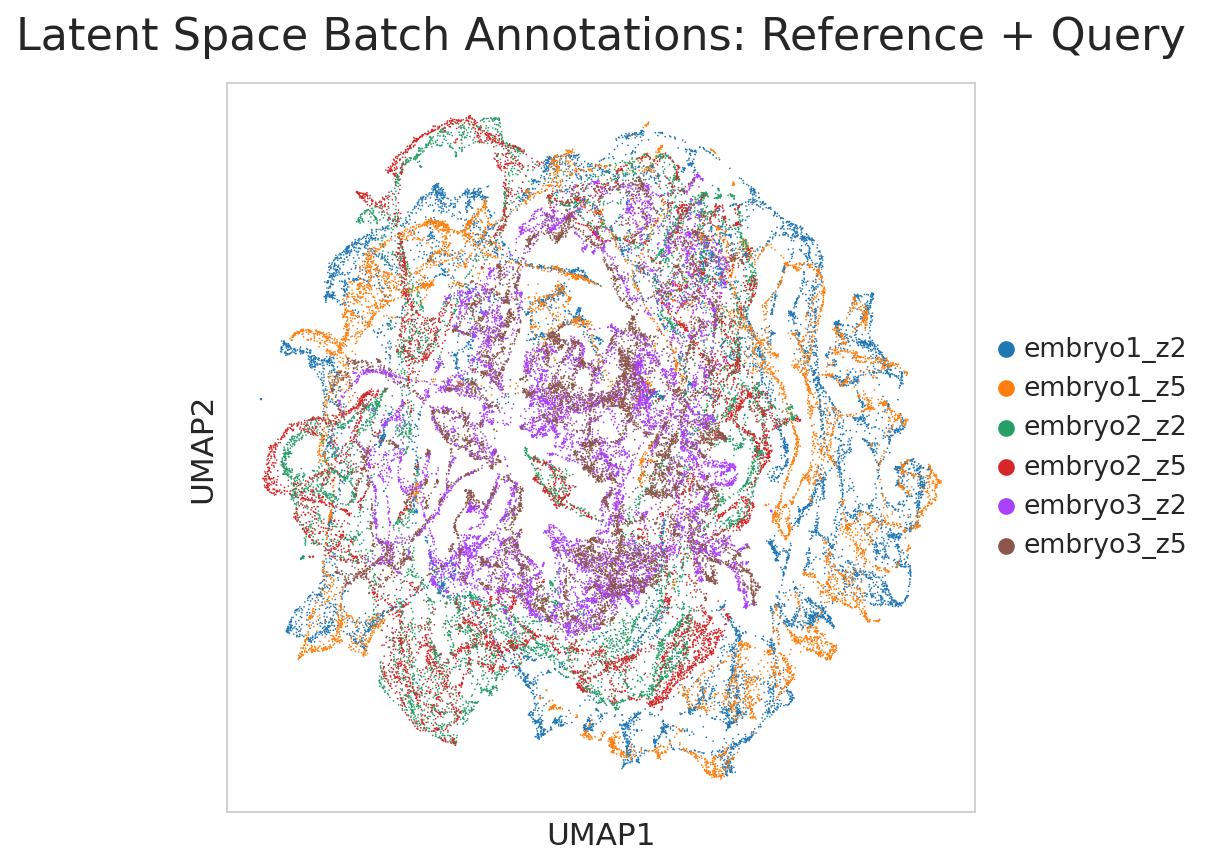

In [52]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_reference_query,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Latent Space Batch Annotations: Reference + Query", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_reference_query.png",
            bbox_inches="tight")

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


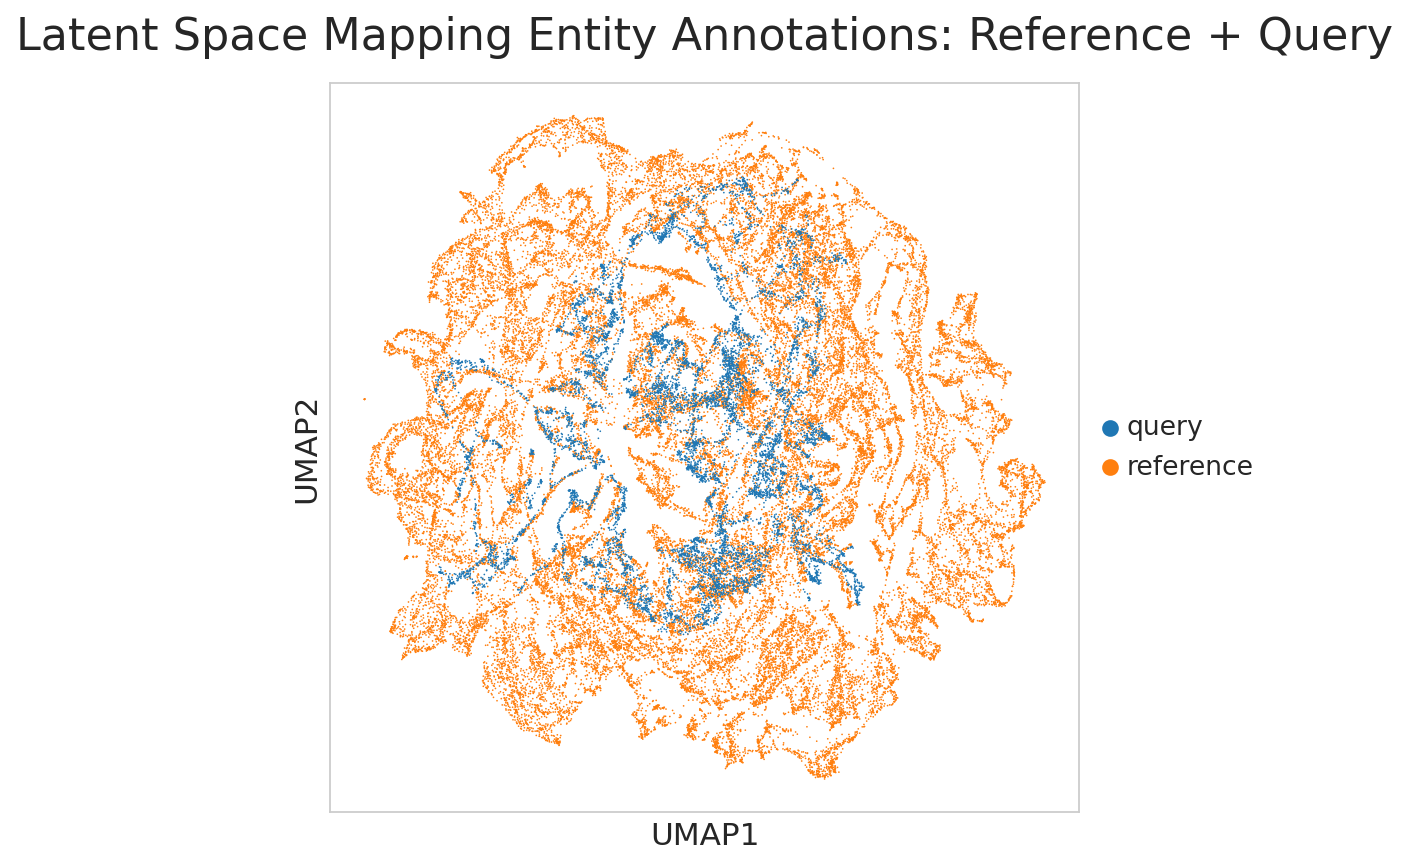

In [57]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_reference_query,
                 color=["mapping_entity"],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Latent Space Mapping Entity Annotations: Reference + Query", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_mapping_entities_reference_query.png",
            bbox_inches="tight")

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


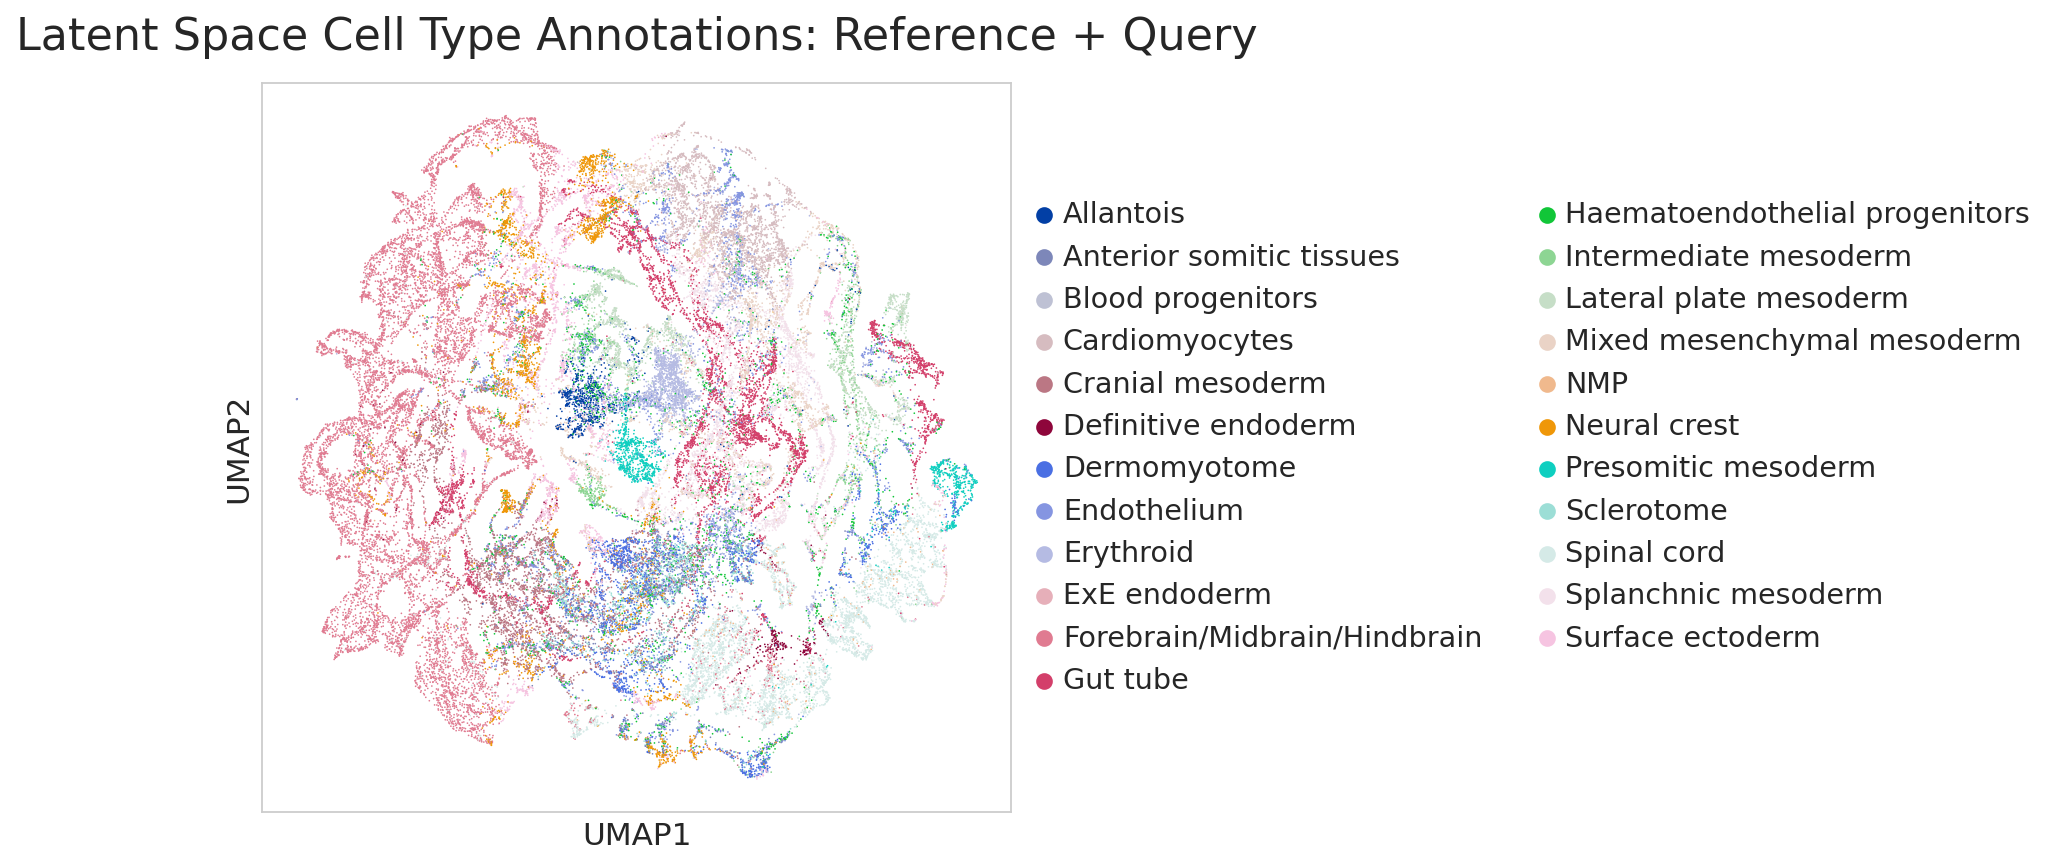

In [58]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata_reference_query,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("Latent Space Cell Type Annotations: Reference + Query", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_reference_query.png",
            bbox_inches="tight")

##### 3.4.2.4 Analyze Batch Correction Metrics

In [59]:
batch_correction_metrics_reference_query = {}

batch_correction_metrics_reference_query["silhouette_batch"] = scib.me.silhouette_batch(
    adata_reference_query,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(batch_correction_metrics_reference_query)

# Store to disk
with open(f"{model_artifacts_folder_path}"
          "/batch_correction_metrics_reference_query.pickle", "wb") as f:
    pickle.dump(batch_correction_metrics_reference_query, f)

mean silhouette per group:                                 silhouette_score
group                                           
Allantois                               0.922523
Anterior somitic tissues                0.956229
Blood progenitors                       0.924938
Cardiomyocytes                          0.972562
Cranial mesoderm                        0.958383
Definitive endoderm                     0.922662
Dermomyotome                            0.946942
Endothelium                             0.969961
Erythroid                               0.953598
ExE endoderm                            0.910864
Forebrain/Midbrain/Hindbrain            0.978191
Gut tube                                0.955880
Haematoendothelial progenitors          0.977793
Intermediate mesoderm                   0.950243
Lateral plate mesoderm                  0.951706
Mixed mesenchymal mesoderm              0.956011
NMP                                     0.935618
Neural crest                            0.

##### 3.4.2.5 Analyze Conditional Embedding

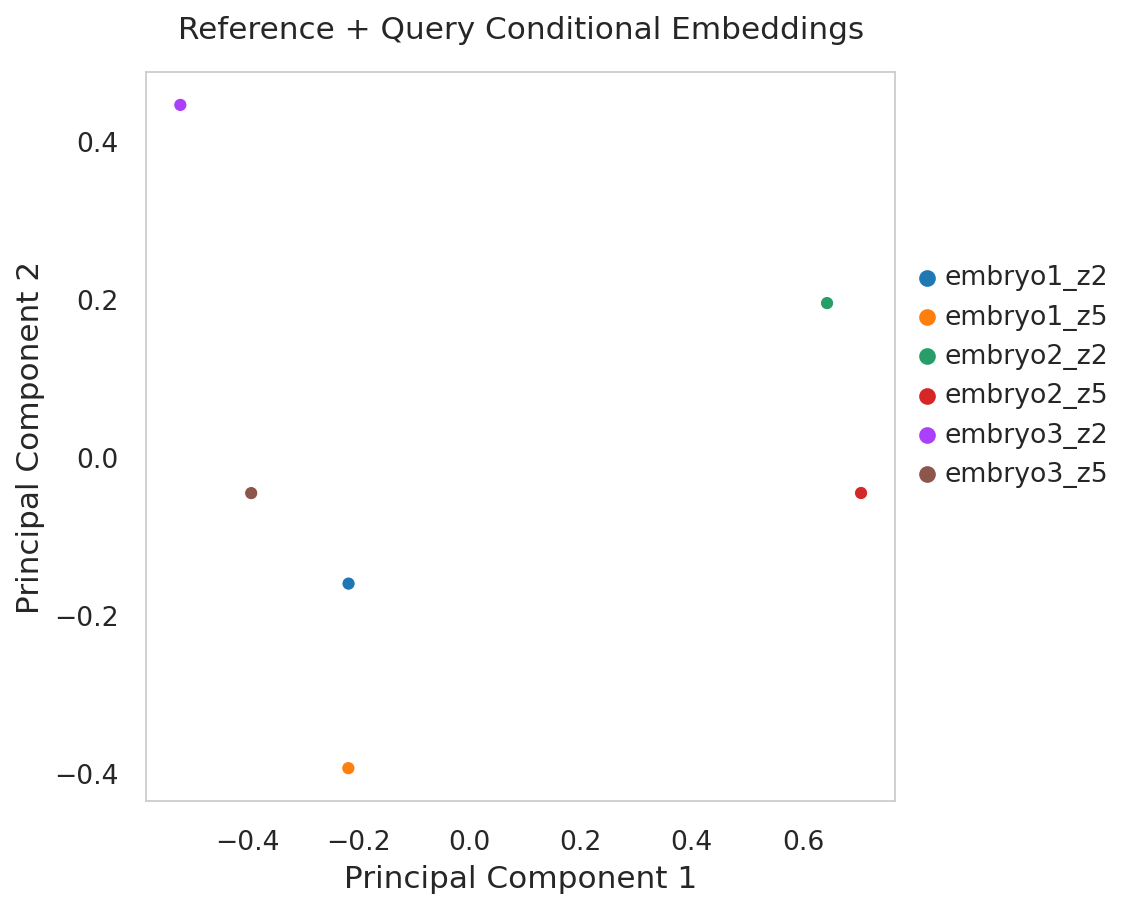

In [60]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
cond = adata_reference_query.obs["batch"].unique()

# Get top 2 principal components and plot them
pca = KernelPCA(n_components=2, kernel="linear")
cond_embed_pca = pca.fit_transform(cond_embed)
sns.scatterplot(x=cond_embed_pca[:, 0], 
                y=cond_embed_pca[:, 1], 
                hue=cond)
plt.title("Reference + Query Conditional Embeddings", pad=15)
plt.xlabel("Principal Component 1")
plt.xticks(fontsize=12)
plt.ylabel ("Principal Component 2")
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.75),
           loc=2,
           borderaxespad=0.,
           fontsize=12,
           frameon=False)
plt.savefig(f"{figure_folder_path}/reference_query_cond_embed.png",
            bbox_inches="tight")